## Using `bracket_builder` to calculate conditional probabilities to feed into R script for viz

In [1]:
import os
import sys
import pandas as pd
from datetime import datetime
import bracket_builder.draw as bb
import bracket_builder.calculate as brac_calc

### Test out drawing standard 64 team bracket

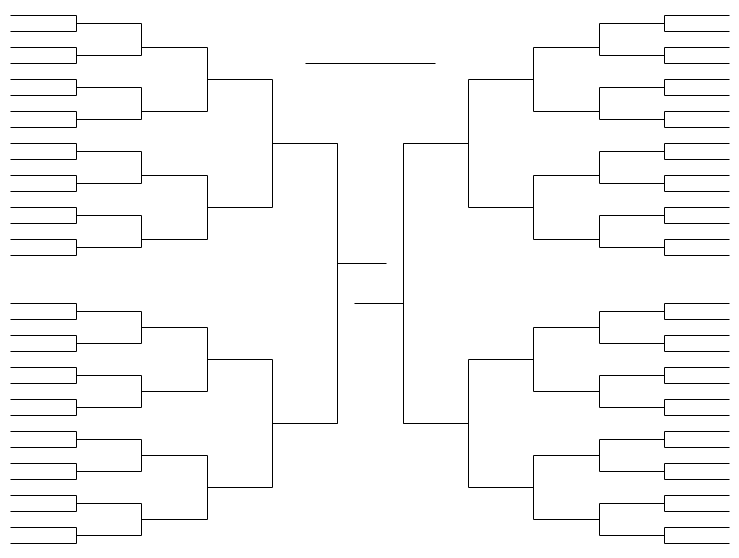

In [2]:
b = bb.Bracket(64)
b.draw_bracket()

### Adding names

In [3]:
os.chdir("../data/men/")

In [4]:
## Get past tournament data to test with
seeds = pd.read_csv("stage_2/MNCAATourneySeeds.csv")
teams = pd.read_csv("stage_2/MTeams.csv")
seeds = seeds.merge(teams[['TeamID', 'TeamName']])
ncaa_slots = pd.read_csv("stage_2/MNCAATourneySlots.csv")

In [5]:
def remove_one_playin(ncaa_data):
    
    ### Remove the play-in seed with the seed starting with "b" for now
    #### Would ideally choose the one with the greater win prob. but doesn't matter much
    ncaa_data['seed_endswith_b'] = ncaa_data['Seed'].apply(lambda x: True if x.endswith('b') else False)
    ncaa_data = ncaa_data[~ncaa_data['seed_endswith_b']].copy()
    
    ## Change the Seed for the one starting with a
    ncaa_data['Seed'] = ncaa_data['Seed'].apply(lambda x: x[:-1] if x.endswith('a') else x)
    
    ## Drop the seed_endswith_b column
    ncaa_data = ncaa_data.drop(columns = ['seed_endswith_b'])
    
    return ncaa_data

In [6]:
### Limit to current season
seeds_2022 = seeds[seeds['Season'] == 2022].copy()

## Remove the 'b' play-in seeds and remove 'a' suffix from the deemed 'winner'
seeds_2022 = remove_one_playin(seeds_2022)

## Split the seed into Region and number parts
seeds_2022['seed_num']      = seeds_2022['Seed'].apply(lambda x: int(x[1:]))
seeds_2022['seed_region']   = seeds_2022['Seed'].apply(lambda x: x[0])
seeds_2022['seed_region_2'] = seeds_2022['seed_region'].apply(lambda x: 'W' if x == 'X'
                                                               else 'X' if x == 'W'
                                                               else 'Z' if x == 'Y'
                                                               else 'Y' if x == 'Z'
                                                               else x)

## Proper ordering for seeds within each region in the 1st round
seed_order = pd.DataFrame({'seed_num': [1, 16, 8, 9, 5, 12, 4, 13, 6, 11, 3, 14, 7, 10, 2, 15],
                           'seed_ord': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]})
seeds_2022 = seeds_2022.merge(seed_order)

## Sort it properly and check it out
seeds_2022 = seeds_2022.sort_values(['seed_region_2', 'seed_ord'])
seeds_2022.head(16)

,Season,Seed,TeamID,TeamName,seed_num,seed_region,seed_region_2,seed_ord
23,2022,X01,1211,Gonzaga,1,X,W,1
56,2022,X16,1209,Georgia St,16,X,W,2
31,2022,X08,1129,Boise St,8,X,W,3
32,2022,X09,1272,Memphis,9,X,W,4
19,2022,X05,1163,Connecticut,5,X,W,5
47,2022,X12,1308,New Mexico St,12,X,W,6
1,2022,X04,1116,Arkansas,4,X,W,7
50,2022,X13,1436,Vermont,13,X,W,8
12,2022,X06,1104,Alabama,6,X,W,9
11,2022,X11,1323,Notre Dame,11,X,W,10


In [7]:
## Get submission for round 2
subs_path = "subs/submission_probs_untrimmed_2022-03-14.csv"
sub = pd.read_csv(subs_path)
sub['Season'] = sub['ID'].apply(lambda x: x.split('_')[0]).astype(int)
sub['TeamID_1']  = sub['ID'].apply(lambda x: x.split('_')[1]).astype(int)
sub['TeamID_2']  = sub['ID'].apply(lambda x: x.split('_')[2]).astype(int)

## Merge team 1 name
teams = teams.rename(columns={'TeamName': 'TeamName_1',
                              'TeamID': 'TeamID_1'})
teams = teams[['TeamName_1', 'TeamID_1']]
sub = sub.merge(teams, on='TeamID_1', how='left')

## Merge team 2 name
teams = teams.rename(columns={'TeamName_1': 'TeamName_2',
                              'TeamID_1': 'TeamID_2'})
sub = sub.merge(teams, on='TeamID_2', how='left')

sub.head()

,ID,Pred,Season,TeamID_1,TeamID_2,TeamName_1,TeamName_2
0,2022_1103_1104,0.153093,2022,1103,1104,Akron,Alabama
1,2022_1103_1112,0.053793,2022,1103,1112,Akron,Arizona
2,2022_1104_1112,0.224861,2022,1104,1112,Alabama,Arizona
3,2022_1103_1116,0.129493,2022,1103,1116,Akron,Arkansas
4,2022_1104_1116,0.431512,2022,1104,1116,Alabama,Arkansas


In [8]:
round_by_round_probs_df = brac_calc.compute_conditional_probs(subs_path, season = 2022, league = 'men')

round_by_round_probs_df.sort_values('Champ', ascending = False).head(20)

,TeamName,TeamID,Round1,Round2,Sweet16,Elite8,Final4,Final,Champ
18,Gonzaga,1211,1.0,0.976734,0.855339,0.736802,0.563519,0.408043,0.293786
2,Arizona,1112,1.0,0.961661,0.765374,0.458993,0.273307,0.166049,0.077422
25,Kansas,1242,1.0,0.962130,0.703670,0.467574,0.300489,0.156079,0.068922
26,Kentucky,1246,1.0,0.926984,0.674171,0.435193,0.248256,0.114927,0.065189
55,Tennessee,1397,1.0,0.940146,0.721800,0.426256,0.224473,0.132325,0.058497
5,Baylor,1124,1.0,0.952313,0.735828,0.431464,0.247295,0.106147,0.057790
19,Houston,1222,1.0,0.799548,0.579175,0.328132,0.189340,0.113383,0.053175
4,Auburn,1120,1.0,0.926122,0.708949,0.494763,0.261204,0.125437,0.049332
57,Texas Tech,1403,1.0,0.926093,0.699600,0.433764,0.173145,0.090444,0.046967
59,UCLA,1417,1.0,0.930208,0.653042,0.362681,0.206009,0.087570,0.045995


In [9]:
round_by_round_probs_df.to_csv(f"viz-files/round-by-round-probs-untrimmed-{datetime.today().strftime('%Y-%m-%d')}.csv",
                               index = False)

In [10]:
## Submission with Gonzaga manually scaled back some
subs_path = f"subs/submission_probs_untrimmed_{datetime.today().strftime('%Y-%m-%d')}-mod.csv"
round_by_round_probs_df = brac_calc.compute_conditional_probs(subs_path, season = 2022, league = 'men')
round_by_round_probs_df.to_csv(f"viz-files/round-by-round-probs-untrimmed-{datetime.today().strftime('%Y-%m-%d')}-mod.csv",
                               index = False)

round_by_round_probs_df.sort_values('Champ', ascending = False).head(20)

,TeamName,TeamID,Round1,Round2,Sweet16,Elite8,Final4,Final,Champ
18,Gonzaga,1211,1.0,0.963924,0.788208,0.629684,0.426307,0.267608,0.166623
2,Arizona,1112,1.0,0.961661,0.765374,0.458993,0.273307,0.166049,0.088174
25,Kansas,1242,1.0,0.962130,0.703670,0.467574,0.300489,0.156079,0.078420
26,Kentucky,1246,1.0,0.926984,0.674171,0.435193,0.248256,0.136439,0.077391
5,Baylor,1124,1.0,0.952313,0.735828,0.431464,0.247295,0.127657,0.069501
55,Tennessee,1397,1.0,0.940146,0.721800,0.426256,0.224473,0.132325,0.066705
19,Houston,1222,1.0,0.799548,0.579175,0.328132,0.189340,0.113383,0.060205
57,Texas Tech,1403,1.0,0.926093,0.699600,0.433764,0.220175,0.115010,0.059725
4,Auburn,1120,1.0,0.926122,0.708949,0.494763,0.261204,0.125437,0.056906
59,UCLA,1417,1.0,0.930208,0.653042,0.362681,0.206009,0.105325,0.055320


### Plot what it predicts!


In [ ]:
### Label team names (note: had to switch 'Z' and 'Y' region labels.)
b_2 = bb.Bracket(n_teams = 64, team_names = list(seeds_2022['TeamName']))
b_2.draw_bracket()
b_2.label_teams()

## To-Do

  1. Fix up the `label_winners()` function and/or get a pipeline to easily get winners in required order
  2. Complete the `draw_weighted_lines()` function to draw lines in the team's colors.
  3. Get a pipeline in `calculate` going to `compute_conditional_probs()` in a way that works seamlessly with weighted lines.